In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import KolmogorovEnvironment4, KolmogorovEnvironment5, KolmogorovEnvironment6
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
#from lib.models import FcNN, MyFCNNActorProb, MyFCNNActorProb2, MyFcnnActor, MyCritc, Backbone
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [3]:
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
                  99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
                  160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]

train_seeds = seeds[:30]
val_seeds = seeds[30:]
test_seeds = np.array([69, 33, 420])

print(train_seeds)
print(val_seeds)

[102 348 270 106  71 188  20 121 214 330  87 372  99 359 151 130 149 308
 257 343 413 293 385 191 276 160 313  21 252 235]
[344  42]


m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0
Correlation: 0.9987303597646554
MSE: 7.004406283613535e-05
NMSE: 0.00010251326594050758


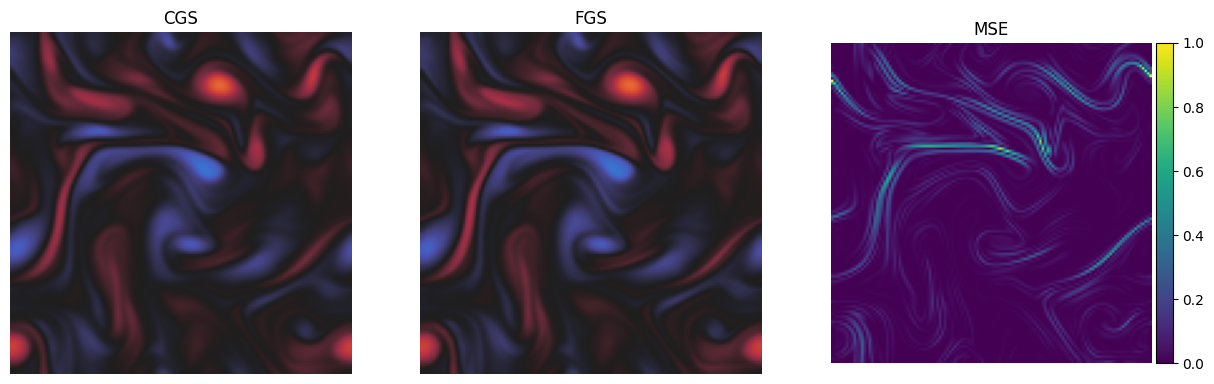

In [4]:
test_env = KolmogorovEnvironment6(seeds=val_seeds)
test_env.render()

In [ ]:
# TODO: iterate through all seeds and print intial voriticity in a grid


In [ ]:
# TODO: plot energy spectrum over the coarse of a simulation between fgs and cgs

In [ ]:
# TODO: think of other statistics that could be used

In [3]:
env2 = KolmogorovEnvironment6(max_episode_steps=1536-1)

#######################################################################################################
u0_path = f"/home/pfischer/XLB/vel_init/velocity_burn_in_2_909313_s102.npy" #2048x2048 simulation
rho0_path = f"/home/pfischer/XLB/vel_init/density_burn_in_2_909313_s102.npy" #2048x2048 simulation
kwargs1, T1,_,_ = get_kwargs(u0_path=u0_path, desired_time=1.4, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, T2,_,_ = get_kwargs(u0_path=u0_path, desired_time=1.4, rho0_path=rho0_path, lamb=16) #fgs
env1 = KolmogorovEnvironment5(kwargs1, kwargs2, max_episode_steps=1536-1)

m = 413.8446729551238, m_prime = 2048.0, end time = 2048 steps, T=24, io_rate = 64.0, Number of outputs = 34.0
m = 6621.514767281981, m_prime = 32768.0, end time = 32768 steps, T=24, io_rate = 1024.0, Number of outputs = 34.0
m = 413.8446729551238, m_prime = 2048.0, end time = 2048 steps, T=24, io_rate = 64.0, Number of outputs = 34.0
m = 6621.514767281981, m_prime = 32768.0, end time = 32768 steps, T=24, io_rate = 1024.0, Number of outputs = 34.0


In [ ]:
#time one klmgrv5 episode
start_time = time.time()

# play one entire episode
# just plays one episode
reward = 0
step = 0
act = np.ones(env2.action_space.shape)
obs ,inf = env2.reset()
episode_is_over = False
while not episode_is_over:
    if step%100==0:
        print(step)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env2.render()
    obs, rew, terminated, truncated, inf = env2.step(act)
    reward += rew
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env1.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")